In [23]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO

In [24]:
with open("imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
# 1. Load the pretrained model

model = torchvision.models.vgg19(pretrained=True)
model.to(device)
model.eval()
print("VGG19 model loaded and set to eval mode.\n")

c:\Anaconda3\envs\models\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Anaconda3\envs\models\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG19 model loaded and set to eval mode.



In [27]:
# 2. Utility: Load an Image from URL

def load_image_from_url(url):
    """Load an image from a URL and return it as a PIL Image."""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

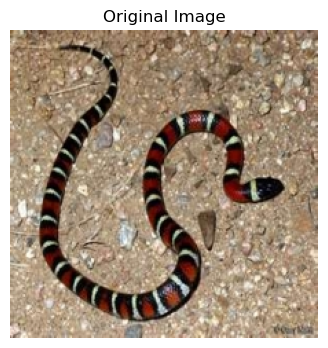

In [28]:
url = "https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/snake.png?raw=true"

try:
    img = load_image_from_url(url)
except Exception as e:
    print("Error loading image from URL:", e)
    print("Please replace 'url' with a working link or a local file path.")
    raise SystemExit

# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

In [30]:
# 3. Preprocess the Image for VGG19

# Mean and standard deviation of the ImageNet dataset
# These are used to normalize the image before passing it to the model


img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
         mean=[0.485, 0.456, 0.406],  
         std =[0.229, 0.224, 0.225]
    )
])

input_tensor = img_transform(img).unsqueeze(0).to(device)

print(input_tensor.shape)

torch.Size([1, 3, 224, 224])


In [31]:
# 4. Vanilla Gradient (Saliency Map)

def compute_saliency(model, input_tensor, target_class=None, classes=None):
    """
    Compute the gradient of the score (for a particular target_class)
    w.r.t. the input_tensor. Returns the gradient (saliency) and the
    class index actually used.

    Args:
      model (nn.Module): The neural network, in eval mode.
      input_tensor (torch.Tensor): shape [1, C, H, W].
      target_class (int or None or str): If None, uses predicted class.
         If int, uses that index. If str, finds index in 'classes'.
      classes (list of str, optional): only needed if target_class is str.

    Returns:
      gradient (torch.Tensor): same shape as input_tensor
      used_idx (int): the integer index for the class used
    """
    input_tensor = input_tensor.clone()
    input_tensor.requires_grad = True

    # Forward pass
    output = model(input_tensor)

    # If user provided a string label, convert to index
    if isinstance(target_class, str) and (classes is not None):
        target_class = classes.index(target_class)

    # If no target_class given, take argmax
    if target_class is None:
        target_class = output.argmax(dim=1).item()

    # Zero out existing gradients
    model.zero_grad()

    # Select the logit for target_class
    score = output[0, target_class]

    # Backprop to get gradients
    score.backward()

    # Extract the gradient from input_tensor
    gradient = input_tensor.grad.data.clone()

    # Detach so subsequent calls won't accumulate more gradient
    input_tensor.grad.data.zero_()
    input_tensor.requires_grad = False

    return gradient, target_class

Predicted class: king snake


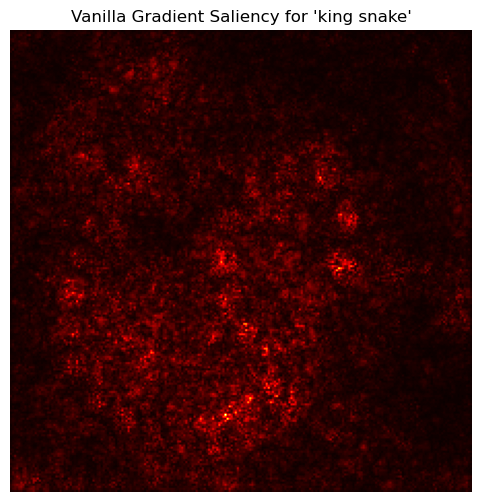

In [32]:
# Predict the class of the input image
with torch.no_grad():
    out = model(input_tensor)
pred_idx = out.argmax(dim=1).item()
pred_label = classes[pred_idx]
print("Predicted class:", pred_label)

# Now, compute the saliency map using the real label
saliency, used_idx = compute_saliency(model, input_tensor, target_class=pred_label, classes=classes)
saliency = saliency.abs()  # Take absolute value for visualization

# Convert saliency to numpy and process for visualization
# Convert saliency to numpy and process for visualization
saliency_np = saliency[0].detach().cpu().numpy()
vanilla_map = np.max(saliency_np, axis=0)
vanilla_map -= vanilla_map.min()
vanilla_map /= (vanilla_map.max() + 1e-8)

# Visualize the saliency map
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.imshow(vanilla_map, cmap='hot')
plt.title("Vanilla Gradient Saliency for '{}'".format(pred_label))
plt.axis('off')
plt.show()


In [33]:
# 5. SmoothGrad function

def smooth_grad(model, input_tensor, n_samples=50, noise_level=0.2, target_class=None):
    """
    Compute SmoothGrad by averaging gradient saliency maps over multiple
    noisy versions of the input.

    Parameters:
      model (torch.nn.Module):
        The neural network model in evaluation mode.
      input_tensor (torch.Tensor):
        Preprocessed input image tensor of shape [1, C, H, W].
      n_samples (int):
        Number of noisy samples to generate and average (default: 50).
      noise_level (float):
        Relative std for the Gaussian noise to add (default: 0.2).
      target_class (int or str, optional):
        The target class for which to compute the saliency map. If None,
        the top predicted class will be used.

    Returns:
      torch.Tensor:
        The smoothed saliency map (gradient) of the same shape as input_tensor.
    """
    smooth = torch.zeros_like(input_tensor)
    data_range = input_tensor.max() - input_tensor.min()
    stdev = noise_level * data_range.item()

    for i in range(n_samples):
        noise = torch.randn_like(input_tensor) * stdev
        noisy_input = input_tensor + noise

        sal, _ = compute_saliency(model, noisy_input, target_class=target_class)
        smooth += sal

    smoothed_gradient = smooth / n_samples
    return smoothed_gradient

In [34]:
# 6. Compute SmoothGrad saliency for the predicted class

smooth_sal = smooth_grad(model, input_tensor, n_samples=50,
                         noise_level=0.2, target_class=pred_idx)
smooth_sal = smooth_sal.abs()

smooth_sal_np = smooth_sal[0].detach().cpu().numpy()
smooth_map = np.max(smooth_sal_np, axis=0)
smooth_map -= smooth_map.min()
smooth_map /= (smooth_map.max() + 1e-8)

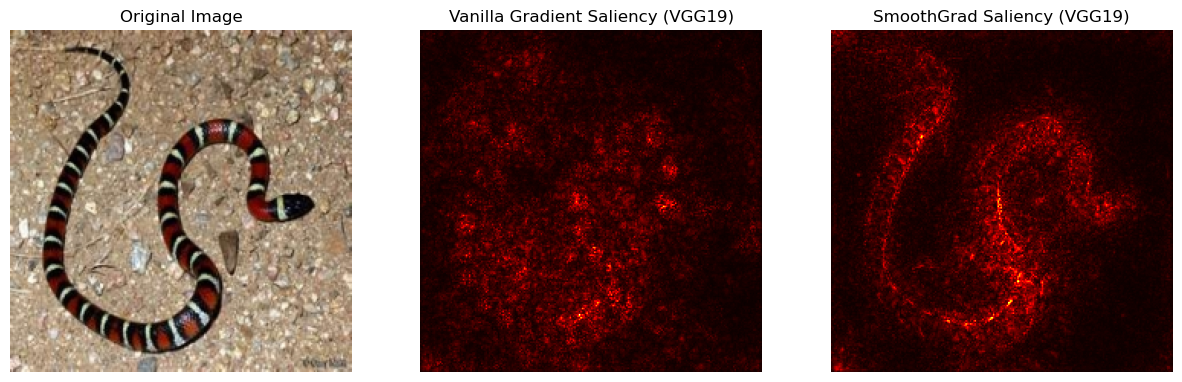

In [35]:
# 7. Visualize Original, Vanilla Grad, and SmoothGrad

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[0].axis("off")

# Vanilla gradient saliency
axs[1].imshow(vanilla_map, cmap='hot')
axs[1].set_title("Vanilla Gradient Saliency (VGG19)")
axs[1].axis("off")

# SmoothGrad saliency
axs[2].imshow(smooth_map, cmap='hot')
axs[2].set_title("SmoothGrad Saliency (VGG19)")
axs[2].axis("off")

plt.show()